In [85]:
vars=['tc','sfc_type','sk_temp','qv','oe_wvp','near_sfc_precip']

d={}
import numpy as np
surface='ocean'
with open('../GMI-models/scaler_1d_%s.txt'%surface ,'r') as f:
    lines = f.readlines()
    ic=0
    for i in range(6):
        var_name = lines[ic]
        ic += 1
        var_mean = np.array([float(v) for v in lines[ic].split()])
        ic += 1
        var_std = np.array([float(v) for v in lines[ic].split()])
        ic += 1
        d[var_name[:-1]] = [var_mean, var_std]

print(d)

{'tc': [array([172.58295, 101.09319, 194.71022, 132.48866, 219.26488, 218.11345,
       163.62964, 257.93765, 229.89326, 271.30518, 266.49127, 258.22556,
       266.8596 ]), array([20.9655  , 32.31992 , 19.623337, 31.60958 , 22.2808  , 14.723263,
       27.47244 , 15.023948, 27.124723, 13.967746, 18.726631,  8.970008,
       10.455282])], 'sfc_type': [array([4.46365518]), array([25.11409622])], 'sk_temp': [array([288.79288]), array([11.261115])], 'qv': [array([7.849633]), array([4.943822])], 'oe_wvp': [array([24.916843]), array([17.580933])], 'near_sfc_precip': [array([0.07530318]), array([0.28768516])]}


In [88]:
import glob
files=glob.glob('../output_1d/*.nc')
files=sorted(files)
import netCDF4 as nc
tc_L=[]
sk_temp_L=[]
sfc_type_L=[]
qv_L=[]
prate_L=[]
import tqdm
for f in tqdm.tqdm(files):
    with nc.Dataset(f) as ds:
        #print(ds)
        tc_s1 = ds.variables['tc_s1'][:]
        tc_s2 = ds.variables['tc_s2'][:]
        sk_temp = ds.variables['sk_temp'][:]
        qv = ds.variables['qv'][:]
        sfc_type = ds.variables['surface_type'][:]
        a=np.nonzero(sfc_type==0)
        tc=np.concatenate((tc_s1[a],tc_s2[a]),axis=-1)
        tc_L.extend(tc)
        sk_temp_L.extend(sk_temp[a])
        sfc_type_L.extend(sfc_type[a])
        qv_L.extend(qv[a])
        prate_L.extend(ds.variables['prate'][:,:-2][a])
        #print(ds)
    #break

100%|██████████| 403/403 [00:08<00:00, 44.91it/s]


In [89]:
print(len(tc_L))
tc_L=np.array(tc_L)
tc_scaled=(tc_L-d['tc'][0])/d['tc'][1]
sk_temp_L=np.array(sk_temp_L)
sk_temp_scaled=(sk_temp_L-d['sk_temp'][0])/d['sk_temp'][1]
sfc_type_L=np.array(sfc_type_L)
sfc_type_scaled=(sfc_type_L-d['sfc_type'][0])/d['sfc_type'][1]
qv_L=np.array(qv_L)
qv_scaled=(qv_L[:,-1]-d['qv'][0])/d['qv'][1]

501423


In [90]:
y_scaled=(np.log10(1+np.array(prate_L)/0.1)-d['near_sfc_precip'][0])/d['near_sfc_precip'][1]
print(y_scaled[:,-1].mean(),y_scaled[:,-1].std())
y_log=np.log10(1+np.array(prate_L)[:,-1]/0.1)
y_log_mean=y_log.mean()
y_log_std=y_log.std()
print(y_log_mean,y_log_std)

3.3214593216628656 2.022696917570136
1.0308378 0.58189976


In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
X_input=torch.tensor(np.concatenate((tc_scaled,sfc_type_scaled[:,np.newaxis],sk_temp_scaled[:,np.newaxis],qv_scaled[:,np.newaxis]),axis=-1),dtype=torch.float32)
y_output=torch.tensor((np.log10(1+np.array(prate_L)/0.1)-0.8)/0.5,dtype=torch.float32)


In [92]:
class DenseModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(DenseModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.dropout1 = torch.nn.Dropout(p=0.05)
        self.fc2 = torch.nn.Linear(128, 64)
        self.dropout2 = torch.nn.Dropout(p=0.05)
        self.fc3 = torch.nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = self.fc3(x)
        return x
input_size = X_input.shape[1]
output_size = y_output.shape[1]
model = DenseModel(input_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
num_epochs = 20


In [93]:
ntot=X_input.shape[0]
n_train=int(0.8*ntot)
import torch
X_train=torch.utils.data.TensorDataset(X_input[:n_train],y_output[:n_train])
X_test=torch.utils.data.TensorDataset(X_input[n_train:],y_output[n_train:])
X_train_loader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)

In [94]:
num_epochs = 20
for epoch in range(num_epochs):
    avg_loss = 0
    icount=0
    for i, (inputs, targets) in enumerate(X_train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()
        icount+=1
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss/icount:.4f}')
torch.save(model.state_dict(), 'dense_1D_model_%s.pth'%surface)

Epoch [1/20], Loss: 0.1700
Epoch [2/20], Loss: 0.1407
Epoch [3/20], Loss: 0.1364
Epoch [4/20], Loss: 0.1341
Epoch [5/20], Loss: 0.1322
Epoch [6/20], Loss: 0.1312
Epoch [7/20], Loss: 0.1302
Epoch [8/20], Loss: 0.1293
Epoch [9/20], Loss: 0.1288
Epoch [10/20], Loss: 0.1284
Epoch [11/20], Loss: 0.1277
Epoch [12/20], Loss: 0.1275
Epoch [13/20], Loss: 0.1274
Epoch [14/20], Loss: 0.1269
Epoch [15/20], Loss: 0.1265
Epoch [16/20], Loss: 0.1263
Epoch [17/20], Loss: 0.1261
Epoch [18/20], Loss: 0.1259
Epoch [19/20], Loss: 0.1255
Epoch [20/20], Loss: 0.1254


In [95]:
y_pred=model(X_input[n_train:])
y_pred=y_pred.detach().numpy()
print(np.corrcoef(y_pred[:,-1],y_output[n_train:,-1].detach().numpy())[0,1])
torch.onnx.export(model, X_input[:1,:], 'xdense/x_1d_dense_model_%s.onnx'%surface, export_params=True, verbose=True, input_names=['input'], output_names=['output'])

0.8306208269711768
Exported graph: graph(%input : Float(1, 16, strides=[16, 1], requires_grad=0, device=cpu),
      %fc1.weight : Float(128, 16, strides=[16, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(64, 128, strides=[128, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %fc3.weight : Float(62, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %fc3.bias : Float(62, strides=[1], requires_grad=1, device=cpu)):
  %/fc1/Gemm_output_0 : Float(1, 128, strides=[128, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/fc1/Gemm"](%input, %fc1.weight, %fc1.bias), scope: __main__.DenseModel::/torch.nn.modules.linear.Linear::fc1 # /Users/mgrecu/miniforge3/lib/python3.12/site-packages/torch/nn/modules/linear.py:125:0
  %/Relu_output_0 : Float(1, 128, strides=[128, 1], requires_grad=1, device=cpu) = onnx::Rel

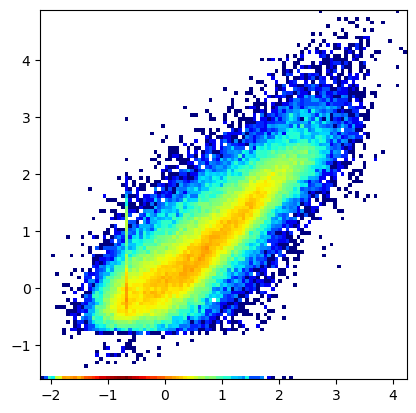

In [96]:
import matplotlib.pyplot as plt
ax=plt.subplot(1,1,1)
import matplotlib
h1=plt.hist2d(y_pred[:,-1].flatten(),y_output[n_train:,-1].detach().flatten(),bins=100,norm=matplotlib.colors.LogNorm(),cmap='jet')
ax.set_aspect('equal', adjustable='box')